# Notebook 8: Model Development
---

In [1]:
import sys
sys.path.append('../scripts')
from model_functions import *
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set(style="white", rc=custom_params)
sns.set_palette('pastel')
colors = sns.color_palette()

from sklearn.metrics import mean_absolute_percentage_error as mape

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [16,5]
plt.rcParams['figure.facecolor'] = 'cornsilk'
plt.rcParams['axes.labelsize'] = 13
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.titlepad'] = 12
plt.rcParams['axes.labelpad'] = 10

## Preprocess the Data
---

In [2]:
df = pd.read_parquet('../clean_data/transformed_data.parquet')

In [3]:
# Split target from features
X, y = df.drop(['nyc_trips_all', 'year', 'season'], axis=1), df[['nyc_trips_all']]

In [4]:
# Split and transform the train and test data
ordinal = ['hour', 'weekday', 'month', 'pandemic_period']
X_train, X_test, y_train, y_test = preprocess_data(X, y, 365, ordinal)

In [5]:
# Review the transformed data
display(X_train.head())
display(y_train.head())

,temp,humidity,precip,windspeed,visibility,nyc_bike_counts,bike_counts_log,hour,weekday,month,weekend,pandemic_period,hour_sin,hour_cos,season_sin,season_cos,rush_hour,is_holiday
date,,,,,,,,,,,,,,,,,,
2018-06-01 00:00:00,0.471241,1.564772,-0.304106,0.027889,-3.708201,-0.637284,-0.211833,0,4,6,-0.633062,0,0.000039,1.414168,1.408917,-0.003546,-0.512812,-0.178269
2018-06-01 01:00:00,0.465049,1.564772,-0.304106,0.027889,-2.629347,-0.929131,-0.794155,1,4,6,-0.633062,0,0.366072,1.365981,1.408917,-0.003546,-0.512812,-0.178269
2018-06-01 02:00:00,0.415514,1.564772,-0.304106,0.346034,-3.708201,-1.092974,-1.451760,2,4,6,-0.633062,0,0.707160,1.224703,1.408917,-0.003546,-0.512812,-0.178269
2018-06-01 03:00:00,0.471241,1.564772,-0.304106,0.027889,-3.708201,-1.143322,-1.819133,3,4,6,-0.633062,0,1.000060,0.999963,1.408917,-0.003546,-0.512812,-0.178269
2018-06-01 04:00:00,0.471241,1.564772,-0.304106,0.027889,-3.708201,-1.113455,-1.583302,4,4,6,-0.633062,0,1.224809,0.707076,1.408917,-0.003546,-0.512812,-0.178269


,nyc_trips_all
date,
2018-06-01 00:00:00,2.599883
2018-06-01 01:00:00,2.278754
2018-06-01 02:00:00,2.060698
2018-06-01 03:00:00,1.869232
2018-06-01 04:00:00,1.869232


## Create the initial model
---

In [6]:
# Create a DataFrame to store the model scores
model_scores = pd.DataFrame(columns=['R2', 'MAPE', 'RMSE', 'Accuracy Rate'])

# Create the initial model
initial_model, y_pred, model_scores.loc[len(model_scores)] = run_regression(X_train, X_test, y_train, y_test)
display(model_scores)

,R2,MAPE,RMSE,Accuracy Rate
0,82.603946,26.77342,892.817856,73.22658


In [7]:
# Review the model's coefficients
display(
    round(pd.DataFrame(initial_model.coef_, index=['Coefficient'], columns=X_train.columns), 5).transpose(
    ).sort_values('Coefficient', ascending=False)
)

,Coefficient
bike_counts_log,0.50100
pandemic_period,0.05958
temp,0.02854
rush_hour,0.02639
visibility,0.01530
weekend,0.00833
humidity,0.00375
weekday,0.00351
windspeed,0.00179
month,0.00007


In [8]:
# Get the confidence intervals
forecast = compile_forecast(y_test, y_pred)
display(forecast)

,Actual,Predicted,Residuals,Lower CI,Upper CI
date,,,,,
2022-06-01 00:00:00,908.00,596.654554,-311.345446,-1435.313136,827.633363
2022-06-01 01:00:00,445.00,239.931288,-205.068712,-1661.493807,529.186868
2022-06-01 02:00:00,287.00,119.259964,-167.740036,-1897.551633,447.254544
2022-06-01 03:00:00,175.00,81.205669,-93.794331,-2017.498587,405.972914
2022-06-01 04:00:00,244.00,121.911421,-122.088579,-1786.855957,432.273507
...,...,...,...,...,...
2023-05-31 19:00:00,6250.85,5505.873664,-744.976336,3415.376008,5827.413099
2023-05-31 20:00:00,5614.00,3427.243513,-2186.756487,1364.608256,3751.524184
2023-05-31 21:00:00,3996.00,3004.126000,-991.874000,994.948673,3242.784833


In [9]:
# Review the results summary statistics
forecast.describe()

,Actual,Predicted,Residuals,Lower CI,Upper CI
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,3042.634943,2398.945095,-643.689848,398.518603,2683.584652
std,2140.731926,1858.715967,618.733226,1859.639158,1859.959783
min,74.000000,44.424250,-3379.709418,-2076.884292,230.788278
25%,901.750000,642.905433,-1060.544600,-1359.150027,922.040870
50%,2892.500000,2144.745835,-545.506536,138.203730,2434.564727
75%,4956.000000,3785.384885,-139.531960,1774.997484,4066.684127
max,6250.850000,6969.802951,2094.223110,4996.615998,7324.274554


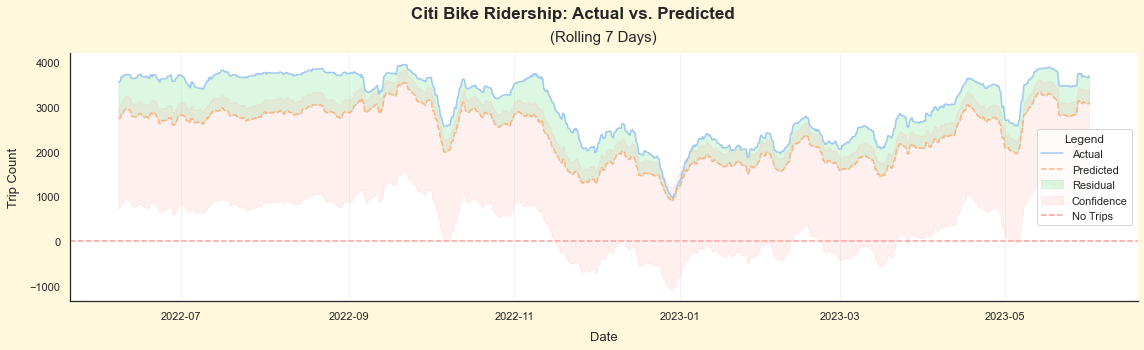

In [10]:
# Plot the actual vs predictions
plot_forecast(forecast, 7)

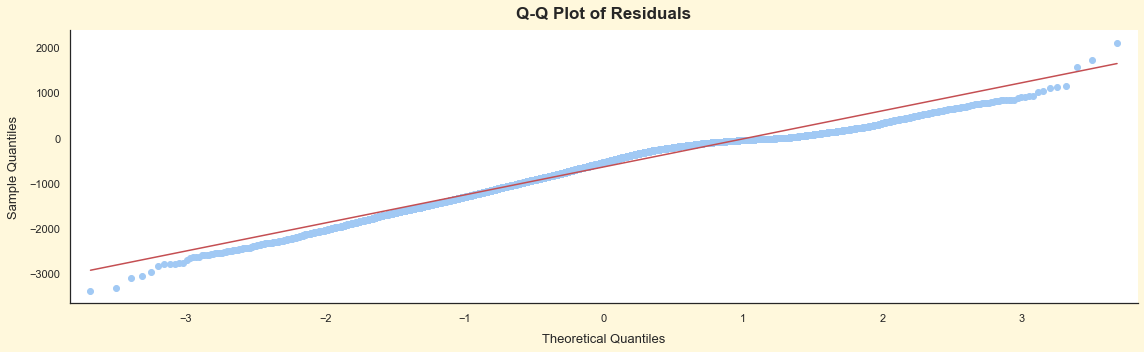

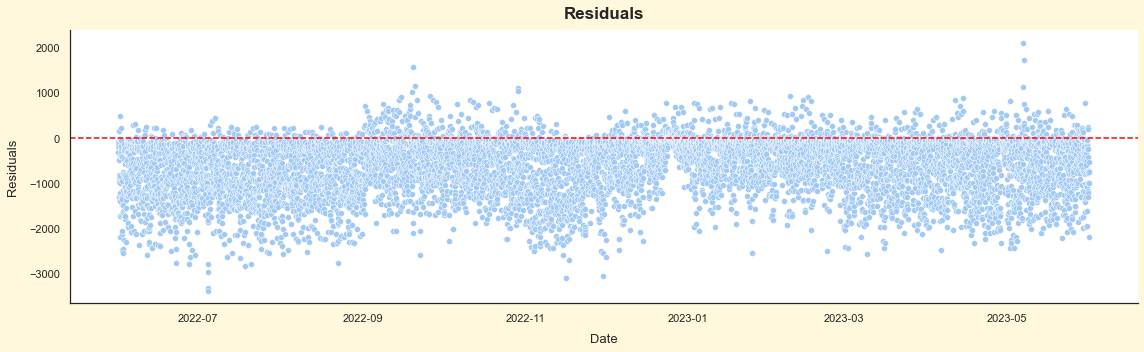

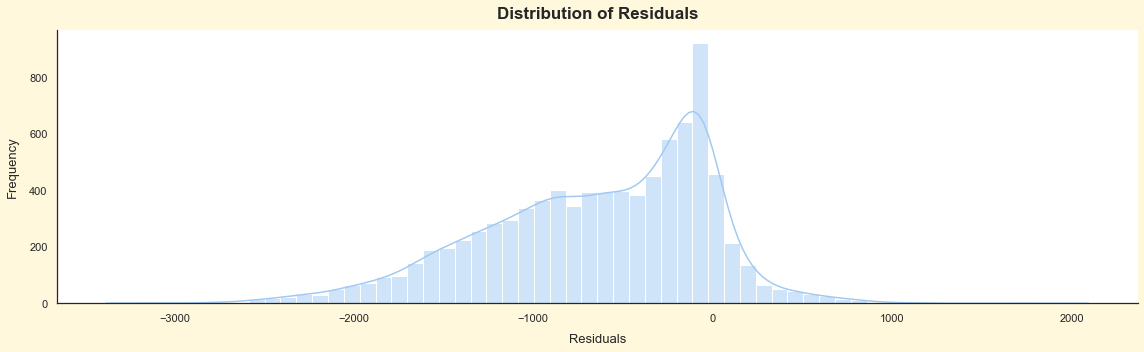

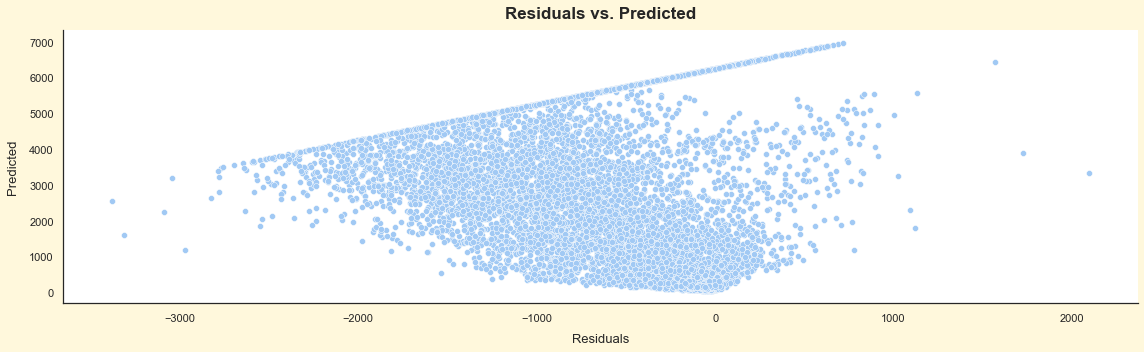

In [11]:
# Plot the residuals
plot_residuals(forecast)

In [12]:
# Conduct the Anderson-Darling test on the residuals
run_anderson(forecast)

Anderson-Darling Test Statistic: 106.2862525800374
15% significance level: Critical Value = 0.576, The residuals deviate from normality.
10% significance level: Critical Value = 0.656, The residuals deviate from normality.
5% significance level: Critical Value = 0.787, The residuals deviate from normality.
2% significance level: Critical Value = 0.918, The residuals deviate from normality.
1% significance level: Critical Value = 1.092, The residuals deviate from normality.


## Get feature importances
---

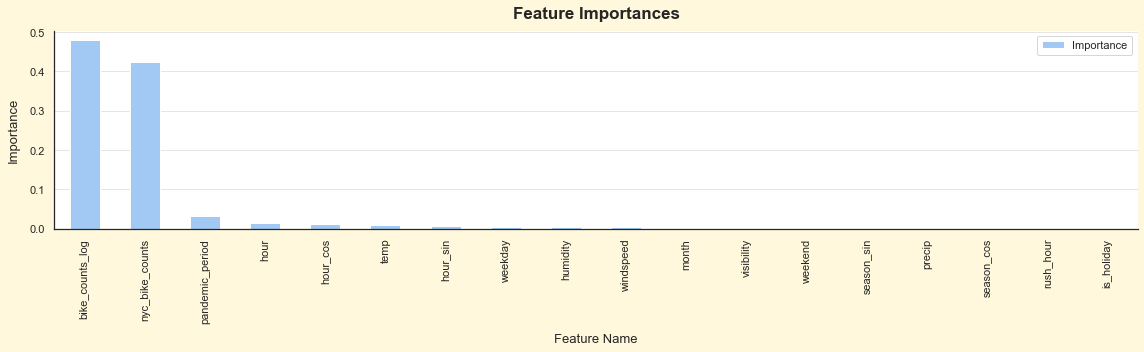

In [13]:
# Get the feature importances
feature_importance = get_feature_importance(X_train, y_train)

In [34]:
feature_importance

,Importance
Feature Name,
bike_counts_log,0.480036
nyc_bike_counts,0.423602
pandemic_period,0.033192
hour,0.013966
hour_cos,0.011677
temp,0.008970
hour_sin,0.006971
weekday,0.004144
humidity,0.003793


In [14]:
# Perform feature selection
best_model = select_features(feature_importance.index, X_train, X_test, y_train, y_test)

,R2,MAPE,RMSE,Accuracy Rate,features
0,82.576690,26.720674,893.517025,73.279326,"Index(['bike_counts_log', 'nyc_bike_counts', '..."
1,82.563356,26.731253,893.858850,73.268747,"Index(['bike_counts_log', 'nyc_bike_counts', '..."
2,82.603946,26.773420,892.817856,73.226580,"Index(['bike_counts_log', 'nyc_bike_counts', '..."
3,82.602524,26.774511,892.854361,73.225489,"Index(['bike_counts_log', 'nyc_bike_counts', '..."
4,82.141698,26.789319,904.602069,73.210681,"Index(['bike_counts_log', 'nyc_bike_counts', '..."
5,82.046127,26.861016,907.019388,73.138984,"Index(['bike_counts_log', 'nyc_bike_counts', '..."
6,81.974155,26.929771,908.835568,73.070229,"Index(['bike_counts_log', 'nyc_bike_counts', '..."
7,82.328163,26.946300,899.867045,73.053700,"Index(['bike_counts_log', 'nyc_bike_counts', '..."
8,82.285179,26.987853,900.960762,73.012147,"Index(['bike_counts_log', 'nyc_bike_counts', '..."
9,82.239800,27.040180,902.113986,72.959820,"Index(['bike_counts_log', 'nyc_bike_counts', '..."


In [15]:
# Store the model scores and select the best features
features = best_model['features']

In [16]:
# View the features
print("Best features:")
for f in features:
    print(f"    {f}")

Best features:
    bike_counts_log
    nyc_bike_counts
    pandemic_period
    hour
    hour_cos
    temp
    hour_sin
    weekday
    humidity
    windspeed
    month
    visibility


## Create and test the new model
---

In [17]:
# Create a new train and test set from the best features
X_train, X_test = X_train[features], X_test[features]

In [18]:
# Create the initial model and find the best alpha value
model, y_pred, model_scores.loc[len(model_scores)] = run_regression(X_train, X_test, y_train, y_test)
display(model_scores)

,R2,MAPE,RMSE,Accuracy Rate
0,82.603946,26.773420,892.817856,73.226580
1,82.576690,26.720674,893.517025,73.279326


In [19]:
# Calculate the model's improvement
for col in model_scores.columns:
    previous = model_scores.at[0, col]
    current = model_scores.at[1, col]
    improvement = (current - previous) / previous * 100
    print(f'{col} Improvement: {improvement:.2f}%')

R2 Improvement: -0.03%
MAPE Improvement: -0.20%
RMSE Improvement: 0.08%
Accuracy Rate Improvement: 0.07%


In [20]:
# Calculate the confidence intervals
forecast = compile_forecast(y_test, y_pred)
forecast.describe()

,Actual,Predicted,Residuals,Lower CI,Upper CI
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,3042.634943,2383.222182,-659.412761,373.748296,2574.254721
std,2140.731926,1828.431375,602.983408,1828.107100,1828.397451
min,74.000000,51.117681,-3347.253131,-2117.144753,179.289563
25%,901.750000,647.993726,-1059.995086,-1360.103916,837.242278
50%,2892.500000,2157.843361,-564.033165,154.463337,2346.569379
75%,4956.000000,3767.495315,-157.009563,1758.749214,3962.304466
max,6250.850000,6682.344803,2422.190338,4743.074174,6932.416082


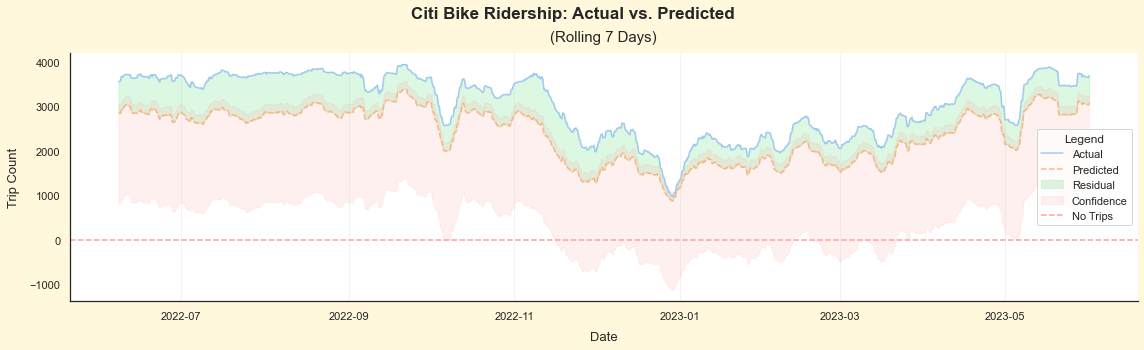

In [21]:
# Plot the rolling mean of the results
plot_forecast(forecast, 7)

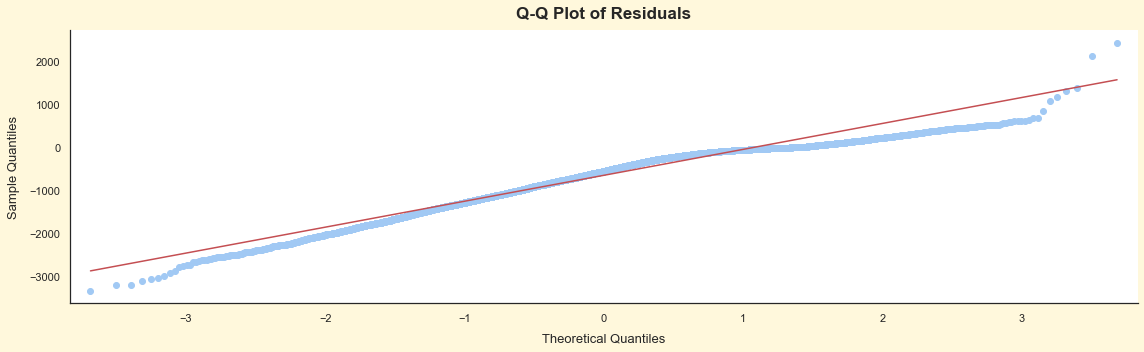

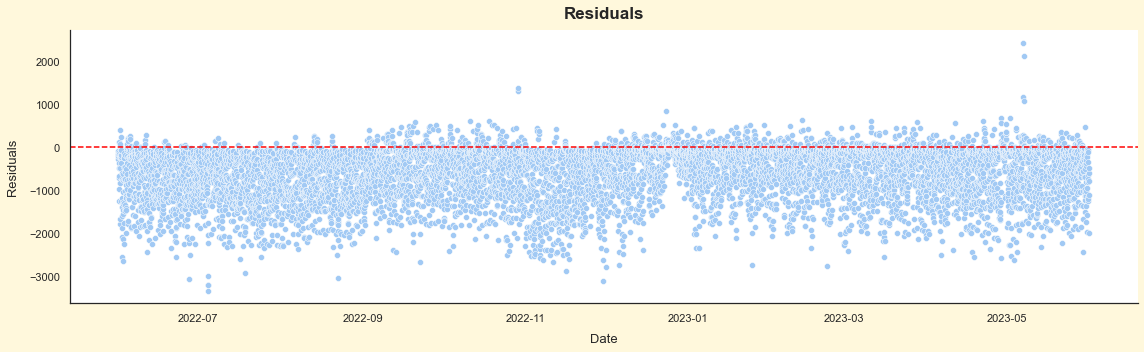

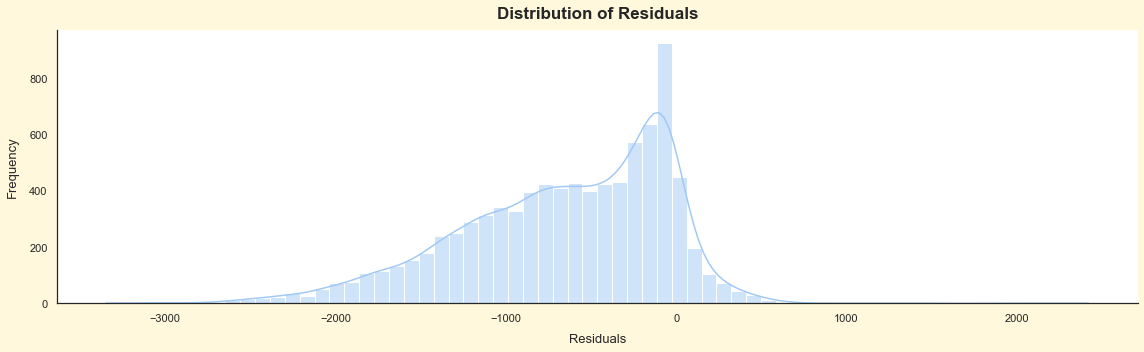

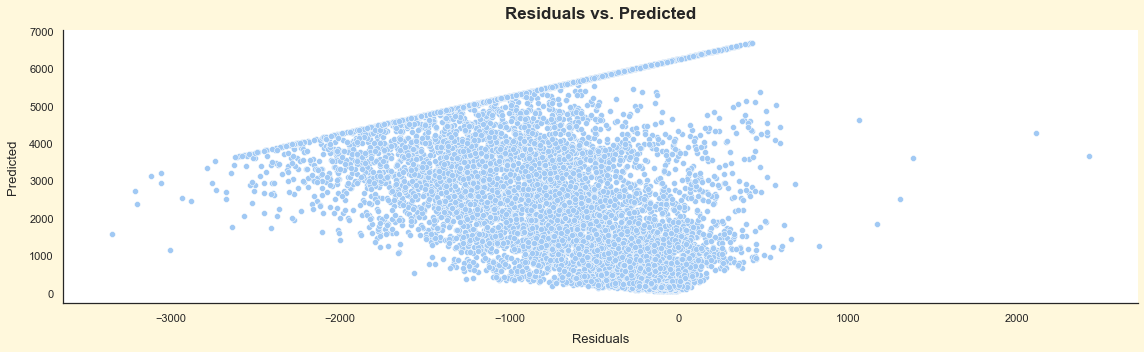

In [22]:
# Visualize the residuals
plot_residuals(forecast)

In [23]:
# Conduct the Anderson-Darling test on the residuals
run_anderson(forecast)

Anderson-Darling Test Statistic: 118.97494561910389
15% significance level: Critical Value = 0.576, The residuals deviate from normality.
10% significance level: Critical Value = 0.656, The residuals deviate from normality.
5% significance level: Critical Value = 0.787, The residuals deviate from normality.
2% significance level: Critical Value = 0.918, The residuals deviate from normality.
1% significance level: Critical Value = 1.092, The residuals deviate from normality.


## Find the best forecast horizon
---

In [24]:
horizon_df = find_horizon(X, y['nyc_trips_all'], ordinal)
display(horizon_df)

,Horizon Months,R2,MAPE,RMSE,Accuracy Rate
0,6,93.18228,18.162727,525.495613,81.837273
1,5,92.174215,18.628628,576.675238,81.371372
2,7,91.964794,19.323322,570.505649,80.676678
3,8,91.819664,19.413038,586.461492,80.586962
4,9,90.863411,20.289322,630.175299,79.710678
5,4,89.423541,20.673493,691.671428,79.326507
6,10,88.822602,22.172133,706.348995,77.827867
7,11,85.950098,24.397937,797.64986,75.602063
8,3,84.382304,25.010785,870.949567,74.989215
9,12,83.087357,26.452785,879.327547,73.547215


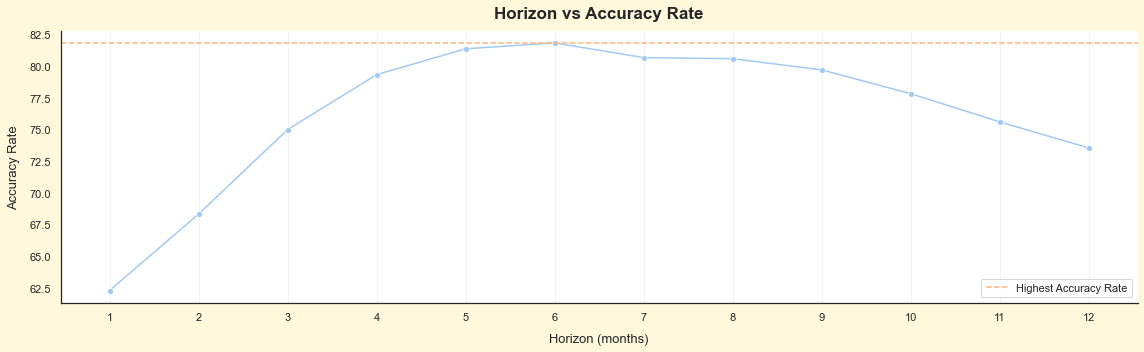

In [25]:
# Plot the RMSE for each forecast horizon
sns.lineplot(x='Horizon Months', y='Accuracy Rate', data=horizon_df, marker='o')
plt.axhline(y=horizon_df.at[0, 'Accuracy Rate'], linestyle='--', c=colors[1], label='Highest Accuracy Rate')

# Add titles and labels
plt.title('Horizon vs Accuracy Rate', size=17, weight='bold')
plt.xlabel('Horizon (months)')
plt.xticks(range(1, len(horizon_df) + 1))

plt.legend()
plt.grid(axis='x', alpha=0.25)
plt.tight_layout()
plt.show()

## Create a new model based on the forecast horizon
---

In [26]:
# Preprocess the data with the best horizon
best_horizon = horizon_df.at[0, 'Horizon Months'] * 30.04
X_train, X_test, y_train, y_test = preprocess_data(df[features], y, best_horizon, ordinal)

In [27]:
# Create and test the model
model, y_pred, model_scores.loc[len(model_scores)] = run_regression(X_train, X_test, y_train, y_test)
display(model_scores)

,R2,MAPE,RMSE,Accuracy Rate
0,82.603946,26.773420,892.817856,73.226580
1,82.576690,26.720674,893.517025,73.279326
2,93.968853,17.655790,494.173999,82.344210


In [28]:
# Calculate the model's improvement
for col in model_scores.columns:
    previous = model_scores.at[1, col]
    current = model_scores.at[2, col]
    improvement = (current - previous) / previous * 100
    print(f'{col} Improvement: {improvement:.2f}%')

R2 Improvement: 13.80%
MAPE Improvement: -33.92%
RMSE Improvement: -44.69%
Accuracy Rate Improvement: 12.37%


In [29]:
# Calculate the confidence intervals
forecast = compile_forecast(y_test, y_pred)
forecast.describe()

,Actual,Predicted,Residuals,Lower CI,Upper CI
count,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000
mean,2628.175231,2537.206430,-90.968801,1365.200058,3486.889049
std,2012.473263,2008.131901,485.785106,2008.120931,2008.679852
min,74.000000,63.979959,-2138.136020,-1211.041454,865.708498
25%,711.000000,698.912401,-322.354759,-466.028903,1647.212978
50%,2354.000000,2214.244173,-50.208867,1046.376641,3168.075809
75%,4199.250000,3923.992415,120.404139,2747.433851,4878.836175
max,6250.850000,7918.063966,3212.836057,6776.746812,8828.729007


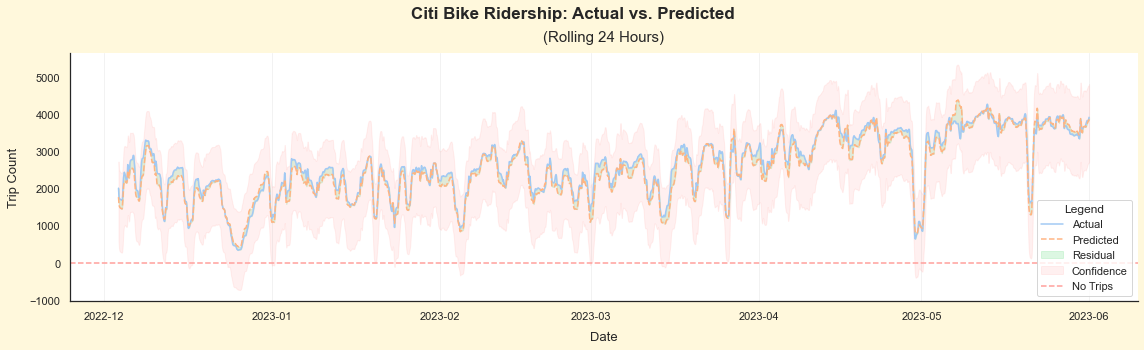

In [30]:
# Plot the actual vs predicted
plot_forecast(forecast, 1)

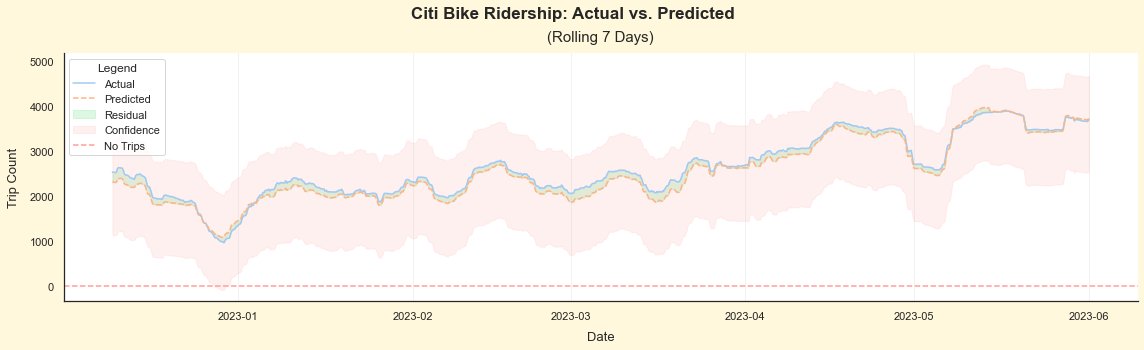

In [33]:
# Plot the actual vs predicted
plot_forecast(forecast, 7)

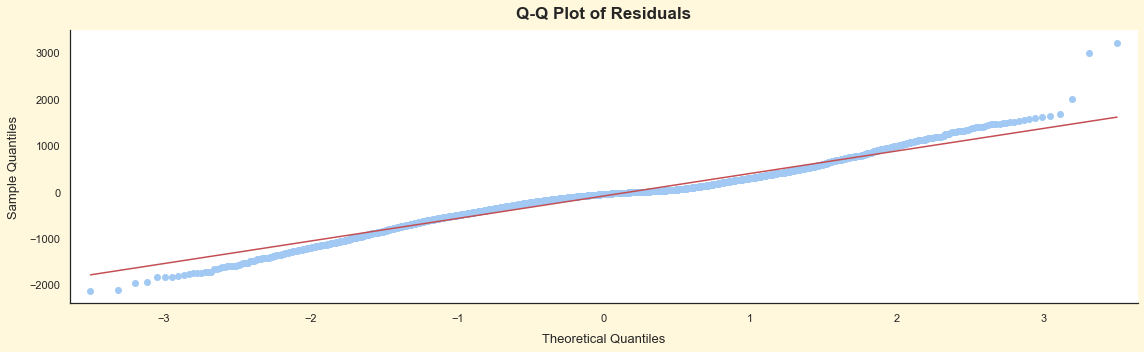

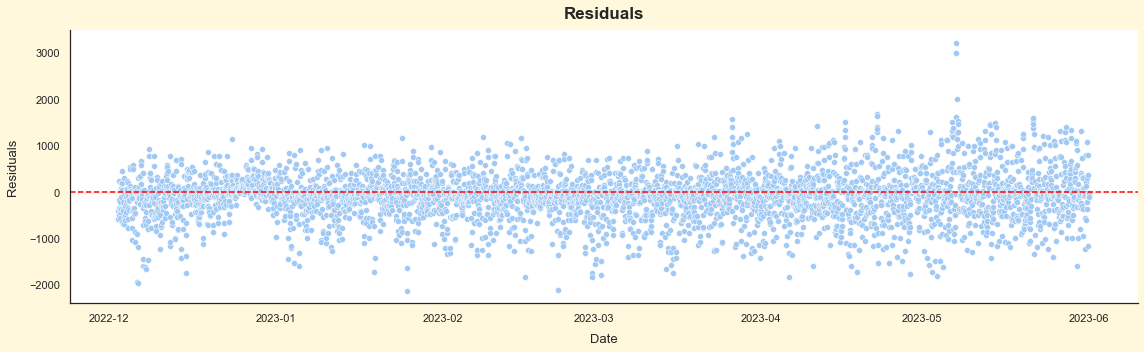

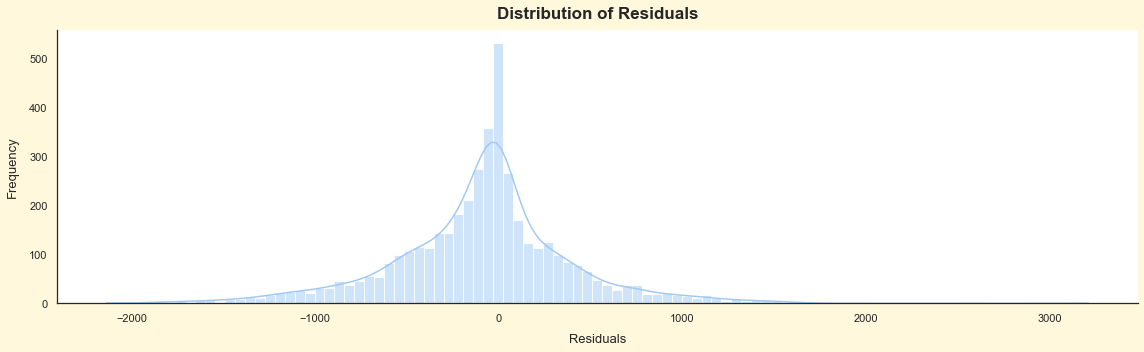

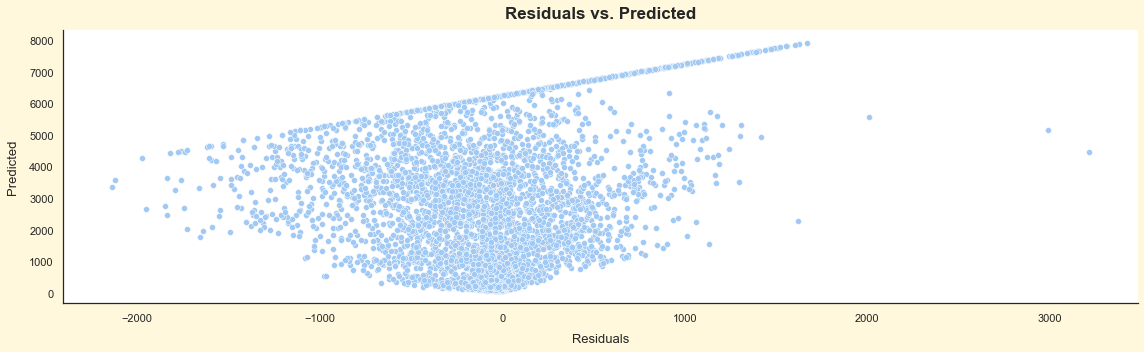

In [32]:
# Plot the residuals
plot_residuals(forecast)

In [31]:
# Test the residual distribution
run_anderson(forecast)

Anderson-Darling Test Statistic: 60.01999822894686
15% significance level: Critical Value = 0.575, The residuals deviate from normality.
10% significance level: Critical Value = 0.655, The residuals deviate from normality.
5% significance level: Critical Value = 0.786, The residuals deviate from normality.
2% significance level: Critical Value = 0.917, The residuals deviate from normality.
1% significance level: Critical Value = 1.091, The residuals deviate from normality.
